# Variational autoencoders

In this project, we will look into the concept of variational autoencoders. We will also create a variational autoencoder using TensorFlow to generate images similar to the MNIST handwritten digits.

## Table of Contents
- [1 - Introduction](#1)
- [2 - Autoencoders](#2)
- [3 - Variational autoencoders](#3)
    - [3.1 - Theory behind VAEs](#3.1)
        - [3.1.1 - Evidence Lower BOund](#3.1.1)
        - [3.1.2 - Variational Inference](#3.1.2)
        - [3.1.3 - Reparameterization Trick](#3.1.3)
        - [3.1.4 - The probability model perspective](#3.1.4)
        - [3.1.5 - The autoencoder perspective](#3.1.5)
- [4 - Implementation](#4)
    - [4.1 - Dimension Reduction using Autoencoders](#4.1)
    - [4.2 - Hand-written Image Generator](#4.2)

<a name='1'></a>
## Introduction
Variational autoencoders (VAEs) are a type of deep generative models that encode input data into a lower-dimensional space, randomly sample points from this latent space, and then decode these points to generate new data. More precisely, VAEs can be viewed in two different ways:

1. VAEs are a type of autoencoder with a key distinction from traditional autoencoders (AEs), which will be explained later when we discuss variational autoencoders.
2. VAEs are probabilistic generative models that operate on the joint distribution of observed and latent variables.

In this notebook, we will provide a brief overview of autoencoders, variational autoencoders, delve into the underlying mathematics, and demonstrate the implementation of both an autoencoder and a variational autoencoder with the MNIST dataset.

<a name='2'></a>
## Autoencoders
An autoencoder is a type of neural network used to reduce high-dimensional data to a lower-dimensional representation. It consists of three parts: encoder, bottleneck, and decoder. The encoder compresses the data to a lower-dimensional form, the bottleneck stores the crucial information, and the decoder reconstructs the output from the bottleneck. During training, the output is compared to the original input to calculate reconstruction loss, which is the squared error between the input and output. Essentially, training an autoencoder involves optimizing the encoder and decoder to minimize the reconstruction error.

Applications of autoencoders include:

- Dimensionality reduction
- Image denoising
- Anomaly detection

| <img src="https://miro.medium.com/v2/resize:fit:600/0*83pAHsVsnsqySOHN.png" width="400" height="300"> | 
|:--:| 
| *Autoencoder architecture* |
*source : [Medium](https://medium.com/@soumallya160/the-basic-concept-of-autoencoder-the-self-supervised-deep-learning-454e75d93a04)*

<a name='3'></a>
## Variational autoencoders

A variational autoencoder (VAE) is a type of probabilistic autoencoder designed to model the distribution of data. They share a similar architecture with standard autoencoders, featuring an encoder, bottleneck, and decoder. However, the way information is processed in the bottleneck of a VAE differs from that of a traditional autoencoder.

VAEs can be understood in two main ways:

1. Probabilistic Generative Model: VAEs function as probabilistic generative models, employing a Bayesian approach to learn the probability distribution of input data.
2. Autoencoder: While VAEs belong to the family of autoencoders, they differ in that they are probabilistic rather than deterministic. In a VAE, the compressed representation (latent vector 𝑧) is not directly learned but is generated randomly based on the learned distribution.


| 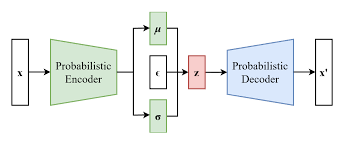 | 
|:--:| 
| *Variational autoencoder architecture* |
*source : [Medium](https://www.google.com/imgres?imgurl=https%3A%2F%2Fmiro.medium.com%2Fv2%2Fresize%3Afit%3A1358%2F0*2DZwupQZTnpBEH1s.png&tbnid=6LvLReF4DrHNNM&vet=12ahUKEwig6JCg5rKEAxX4BfsDHW-xCewQMygSegQIARB0..i&imgrefurl=https%3A%2F%2Fmedium.com%2Fmlearning-ai%2Fvariational-auto-encoders-vae-for-the-numerai-dataset-2709dcc7e449&docid=Zkc9F34LppKCyM&w=1264&h=524&q=variational%20auto%20encoder&ved=2ahUKEwig6JCg5rKEAxX4BfsDHW-xCewQMygSegQIARB0)*

<a name='3.1'></a>
### Theory behind VAEs

<a name='3.1.1'></a>
#### Evidence Lower BOund
The Evidence Lower Bound (ELBO) plays a crucial role in approximating the posterior distribution. It serves as a minimum value for the logarithm of the total likelihood of the data given the model parameters. By maximizing the ELBO, we effectively minimize the Kullback-Leibler (KL) divergence between the actual posterior distribution and the approximated one.

Before delving into the lower bound concept, let's lay out the problem. Let's assume we have two random variables: $X$ (observed or real data) and $Z$ (hidden or latent variable). Both $X$ and $Z$ follow a joint distribution denoted as $p(x,z;\theta)$, where $\theta$ represents the distribution's parameters.

Now, what exactly is the evidence? The evidence simply refers to the log-likelihood of observations 𝑥 under a fixed $\theta$. Essentially, the likelihood function indicates how well our model and parameter $\theta$ match the observations. A high likelihood value suggests that the model fits the data well. Our objective now is to find a lower bound for $p(x;\theta)$. Let's assume that $z$ follows a distribution denoted as 𝑞. We can leverage a technique called marginalization to derive the desired lower bound.

$$\begin{align} log p(x;\theta) &= log\int_{z} p(x,z;\theta) dz \\ &= log\int_{z} p(x,z;\theta) \frac{q(z)}{q(z)} dz \\ &= log E_{z\sim q}[\frac{p(x,Z;\theta)}{q(Z)}] \\ & \geq^* E_{z\sim q}[log \frac{p(x,Z;\theta)}{q(Z)}]\end{align}$$

$$\begin{align} => ELBO = E_{z\sim q}[log \frac{p(x,Z;\theta)}{q(Z)}] \ (1) \end{align}$$

\* : This inequality is the result of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality). Since $log$ is a concave function, $log(E[X]) \geq E[log(X)]$ where X in this statement is $\frac{p(x,Z;\theta)}{q(Z)}$.

Now, let's explain why maximizing the Evidence Lower Bound (ELBO) leads to minimizing the Kullback-Leibler (KL) divergence between the true posterior distribution and the approximating distribution. Let's assume we aim to identify a distribution, denoted as $q$, that accurately approximates $p(z|x; \theta)$. In the context of Variational Autoencoders (VAEs), our goal is to approximate $p(z|x; \theta)$. This requires us to find a distribution that closely approximates it, which is why I am discussing this specific distribution.

$$\begin{align} KL \ (q(z) \ || \ p(z|x;\theta)) &= E_{Z \sim q}[log \frac{q(Z)}{p(Z|x;\theta)}] \\ &= E_{Z \sim q}[log \ q(Z)] - E_{Z \sim q}[log \ p(Z|x;\theta)] \\ &= E_{Z \sim q}[log \ q(Z)] - E_{Z \sim q}[log \frac {p(Z,x;\theta)}{p(x;\theta)}] \\ &= E_{Z \sim q}[log \ q(Z)] - E_{Z \sim q}[log \ p(Z,x;\theta)] + E_{Z \sim q}[log \ p(x;\theta)] \\ &= E_{Z \sim q}[log \ p(x;\theta)] - E_{Z \sim q}[log\frac{p(x,Z;\theta)}{q(Z)}] \\ &=^{*,(1)} log \ p(x;\theta) - ELBO \\ &= evidence - ELBO\end{align}$$

\* : Notice that  $log p(x;\theta)$ is not dependent on  $z$, so it behaves like a constant and can be taken out of the expectation.

Now, consider that when $\theta$ is fixed and we are searching for a distribution q that minimizes the Kullback-Leibler (KL) divergence, the evidence term acts as a constant. Therefore, due to the negative sign of the Evidence Lower Bound (ELBO), maximizing the ELBO results in minimizing the KL divergence.

<a name='3.1.2'></a>
#### Variational Inference

In many real-world situations, it's impractical to calculate the exact probability distribution due to either complex models or large datasets. Variational inference offers a method to estimate this distribution by selecting a simpler distribution from a set of parameterized distributions. The concept of variational inference involves treating the task of approximating the probability distribution as an optimization challenge. The objective is to identify the distribution within the chosen set that minimizes the difference, measured by Kullback-Leibler divergence, from the true distribution.

By maximizing the Evidence Lower Bound (ELBO), a surrogate for the log likelihood of the data based on the model parameters, variational inference aims to find the most precise approximation to the actual probability distribution given the model and observed data.

When dealing with models containing hidden ($Z$) and observed ($X$) variables and trying to determine the likelihood of $Z$ given $X$, variational inference aids in finding a suitable estimation. However, let's first understand why we cannot directly calculate  $p(z|x)$ . By applying Bayes' theorem,  $p(z|x)$  can be expressed as follows:

$$\begin{align} p(z|x) = \frac{p(z,x)}{p(x)} = \frac{p(x|z) \times p(z)}{\int_z p(z,x) dz} \end{align}$$

The key thing to note is that computing the denominator is not always possible. Therefore, variational inference is utilized.

In this method, we select a group of distributions called the variational distribution family and strive to discover a $q$ that comes closest to  $p(z|x)$ within this family. Let's also assume that $\phi$ controls these distributions (it's the variational parameter). Hence, our aim is to identify a $\phi$ that minimizes the KL divergence between  $q_{\phi}(z)$ and  $p(z|x)$ . Interestingly, as indicated by the [Evidence Lower BOund](#3.1.1), instead of minimizing the KL divergence, we can maximize the ELBO to find the most accurate approximation. Therefore, we must now handle $\phi$ as it is a parameter that characterizes the family of distributions.

$$\begin{align} ELBO(\phi) &= L(\phi) = E_{Z \sim q_{\phi}}[log \ p(x,Z) - log \ q(Z)] \\ \hat{\phi} &= argmax_{\phi} \ L(\phi) \end{align}$$

<a name='3.1.3'></a>
#### Reparameterization Trick

In a typical variational inference scenario, our goal is to estimate the distribution of hidden variables using a variational distribution. When the variational distribution involves sampling from a distribution like a Gaussian, it introduces randomness into the calculation of gradients during the optimization procedure. The reparameterization trick helps to tackle this problem by modifying the way the random variable is represented so that the randomness is isolated from the distribution's parameters. This allows gradient-based optimization methods to navigate through the random sampling process, resulting in more consistent training with lower variance gradient estimations. Therefore, this approach enables us to conduct stochastic gradient ascent on the ELBO. Now that we understand how we approximate the hidden variable distribution, we will employ optimization techniques to determine the optimal parameters in our scenario.

##### **High Variance Gradients**
First, let's consider what happens if we don't employ the reparameterization trick. For instance, suppose we aim to compute the gradient with respect to the parameter $\theta$ of the expectation $E_{x \sim p}[f_{\theta}(x)]$. If the distribution $p$ is not determined by $\theta$, then the gradient can straightforwardly be incorporated within the expectation. Nevertheless, if this is not the scenario, then in general, we are unable to compute the gradient.

$$\begin{align} \nabla_{\theta} \ E_{x \sim p_{\theta}}[f_{\theta}(x)] &= \nabla_{\theta} \int_{x} p_{\theta}(x) f_{\theta}(x) dx \\ &= \int_{x}\nabla_{\theta} ( p_{\theta}(x) f_{\theta}(x)) dx \\ &= \int_{x}\nabla_{\theta}p_{\theta}(x) f_{\theta}(x)dx + \int_{x} p_{\theta}(x) \nabla_{\theta} f_{\theta}(x) dx \\ &= \int_{x}\nabla_{\theta}p_{\theta}(x) f_{\theta}(x)dx + E_{x \sim p_{\theta}}[\nabla_{\theta}f_{\theta}(x)]\end{align} $$

The first term in the final expression may not always be an expectation. Monte Carlo methods need the ability to randomly select values from $p(x)$ but don't necessarily need its gradient information. It gets tricky when we can't easily calculate the gradient of $p(x)$ with respect to $\theta$, which is often the case in real-world situations. To make Monte Carlo methods work, we have to make adjustments to eliminate $\nabla_{\theta} p_{\theta}(x)$ from our calculations.

##### **Reparameterization Trick Explanation**
At times, the variable $x$ sampled from $p_{\theta}(x)$ can be represented differently as a fixed function $g$ of $\theta$ and another random variable $\epsilon$ sampled from $D$, where $D$ is independent of $\theta$.
$$\begin{align} \epsilon &\sim D \\ x &= g_{\theta}(\epsilon) \end{align}$$

Now lets see what happen if we take gradient from $E_{x \sim p}[f_{\theta}(x)]$:

$$\begin{align} \nabla_{\theta} \ E_{x \sim p_{\theta}}[f_{\theta}(x)] &= \nabla_{\theta} \ E_{\epsilon \sim g_{\theta}}[f(g_{\theta}(\epsilon))] \\ &=^* E_{\epsilon \sim g_{\theta}}[\nabla_{\theta} f(g_{\theta}(\epsilon))]\end{align} $$

\* : Notice that $\epsilon$ or more generally $D$ are not dependent on $\theta$, so we can move the gradient inside the expectation.

As we showed, now we can use the Monte Carlo method to estimate this expectation.

One may wonder how the $D$ distribution can be determined. Usually, it is not an easy problem, but certain families of distributions lead to straightforward solutions. For instance, in our scenario, where we deal with Gaussian distributions ($q(z|x)$), we can opt for a standard normal distribution and our function $g_{\theta}(\epsilon)$ as: $g_{\theta}(\epsilon) = \mu + \sigma\epsilon$.

To employ the reparameterization trick, we must also consider these requirements:

- $f_{\theta}(x)$ must be differentiable with respect to its input $x$.
- $g_{\theta}(\epsilon)$ must exist and be differentiable with respect to $\theta$.

| <img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60e424b06f61a263edba1fe6_diagrammetic.png" width="400" height="200"> | 
|:--:| 
| *Reparameterization trick* |
*source : [V7 Labs](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.v7labs.com%2Fblog%2Fautoencoders-guide&psig=AOvVaw0-51ffMJPkS80TKsYK3FhU&ust=1708322395990000&source=images&cd=vfe&opi=89978449&ved=0CBMQjRxqFwoTCLDu-YSbtIQDFQAAAAAdAAAAABAP)*

##### **Stochastic Gradient Ascent of the ELBO**
For this aspect, we will apply the following concept to our initial issue, as discussed in [Evidence Lower Bound](#3.1.1) and [Variational Inference](#3.1.2), so all notations and symbols are in relation to these sections.

The aim of utilizing variational inference is to discover the most similar $q$ to $p(z|x)$ by employing continuous optimization methods such as gradient ascent. As a result, parameters are updated at each iteration in the following manner:

$$\begin{align} \phi_{t+1} = \phi_t + \alpha \ \nabla_{\phi} \ L(\phi) \end{align}$$
Notice that we are attempting to maximize the ELBO, so we use gradient ascent.

As we discussed earlier, ELBO involves an average, so the gradients encounter randomness during backpropagation. To eliminate this randomness, we can employ the reparameterization trick. Before delving into this concept, we need to address another issue: how can we calculate gradients? The complexity of our computations arises from dealing with integrals. Hence, we utilize stochastic gradient descent, which assumes a distribution for gradients. At each iteration, a gradient is sampled from that distribution to update the $\phi$. Instead of computing the exact gradient of the ELBO concerning $\phi$, we define a random variable $V(\phi)$ such that $E[V(\phi)] = \nabla_{\phi}L(\phi)$ (this is simply a formal way to represent SGD).
$$\begin{align} v &\sim V(\phi) \\ \phi_{t+1} &= \phi_{t} + \alpha \ v \end{align}$$

First, we will reparameterize $q_{\phi}(z)$ in the following way:
$$\begin{align} \epsilon &\sim N(0,1) \\ z &\sim g_{\phi}(\epsilon) \end{align}$$

Where $g$ has the form that we talked in previous section.

Now we replace every $z$ in ELBO equation with $g_{\phi}$:
$$\begin{align} L(\phi) = E_{\epsilon \sim N(0,1)}[log \ p(x,g_{\phi}(\epsilon)) - log \ q_{\phi}(g_{\phi}(\epsilon))]\end{align}$$

As we demonstrated earlier, this reparameterization allows us to estimate the ELBO using Monte Carlo sampling. We will draw L samples from a standard normal distribution, where the ith sample is denoted as $\epsilon_i$, and then estimate the expectation as:

$$\hat{L(\phi)} = \frac{1}{L} \sum_{l=0}^{L}[log \ p(x,g_{\phi}(\epsilon_l)) - log \ q_{\phi}(g_{\phi}(\epsilon_l))]$$

Since all the requirements are satisfied, we can take the gradient on both sides:
$$\nabla_{\phi} \ \hat{L(\phi)} = \nabla_{\phi} \frac{1}{L} \sum_{l=0}^{L}[log \ p(x,g_{\phi}(\epsilon_l)) - log \ q_{\phi}(g_{\phi}(\epsilon_l))]$$
It is easy to demonstrate that taking the gradient of the loss function ($\nabla_{\phi} L(\phi)$) and calculating its expectation ($E[\nabla_{\phi} L(\phi)]$) are equivalent (simply need to move the $\nabla_{\phi}$ outside the expectation and bring the expectation inside the sigma). Therefore, $E[\nabla_{\phi} L(\phi)]$ is the desired outcome.
$$V(\phi)= \nabla_{\phi} \ \hat{L(\phi)}$$
In simpler terms, when we sample values $\epsilon_1,\dots,\epsilon_L$ from a standard normal distribution ($N(0,1)$), estimate an approximate ELBO, and calculate the gradient for this estimation, it's like randomly selecting gradients from a distribution $V(\phi)$ where the average gradient aligns with the ELBO gradient. This underscores the significance of having $D$ easy to sample from when employing the reparameterization trick: we use samples from $D$ to generate samples for $V(\phi)$.

<a name='3.1.4'></a>
#### The probability model perspective
Now that we have all the necessary tools to explain the complete theory behind VAEs, let's dive into the probabilistic aspect of VAEs.

Variational autoencoders (VAEs) operate as generative models by establishing a joint distribution over samples and their corresponding hidden variable, denoted as $p(x,z)$. To explore this further, let's define the essential components:

- Latent Variable (Z): In VAEs, a hidden variable $z$ plays a vital role in representing intricate data. The model depends on a simplified conditional distribution $p(x,z)$, where $x$ represents observable data, and $z$ remains hidden. This distribution is represented as $p(x,z) = p(x|z)p(z)$, indicating the probability of observed data given the hidden variable and the distribution of the hidden variable itself. This methodology empowers VAEs to capture complex patterns and generate meaningful data representations.
- Observation Variable (X): The variable $x$ in VAEs signifies the observed data, and its distribution is characterized by $p(x|z)$, representing the probability of observing $x$ given a latent variable $z$. This probability distribution guides the VAE framework in learning and generating significant representations of input data, with $z$ capturing concealed patterns and facilitating varied sample generation during training.

The generative process unfolds as follows:

1. Sample a latent variable $z$ from a prior distribution, usually $N(0,I)$.
2. Map $z$ to the parameters of another distribution to sample $x$ using $p(x|z)$.


In Variational Autoencoders (VAEs), both distributions are considered normal distributions. Currently, we can calculate $p(x,z)$ using $p(z)$ and $p(x|z)$ by assuming we have suitable parameters, $\theta$, for them. However, since $z$ is a hidden variable, we lack any information about it in our dataset. Consequently, the primary goal in VAEs is to estimate the posterior distribution, $p(z|x)$, instead of the prior distribution $p(z)$ or the likelihood $p(x|z)$. The hidden nature of the variable $z$ in the dataset sparks an interest in deducing the posterior distribution for each data point, showcasing the model's response to the observed data.

By focusing on $p(z|x)$, VAEs mold the latent space to the specific characteristics of the observed data, integrating information, managing variability, and optimizing for effective reconstruction. This data-driven approach aligns with the generative process, enhancing representation learning and ensuring that the latent space captures meaningful patterns for improved generative capabilities. While seeking $p(z|x)$, we can derive $p(x)$. Thus, our objectives in VAEs are(Assuming we have a dataset containing $x_1,\dots,x_n$, we can simplify the scenario by assuming that they are independently and identically distributed (i.i.d.).):

1. For a fixed $\theta$, compute $p_{\theta}(z_i|x_i)$ for each $x_i$.
2. Maximize the likelihood estimation (MLE) of $\theta$.

Nevertheless, both tasks cannot be computed directly due to the need for approximation. To address this, variational inference is employed. Initially, assuming $\theta$ is fixed, we turn to variational inference and evidence lower bound to approximate $p_{\theta}(z_i|x_i)$. Variational Inference selects a family of distributions and determines the closest distribution to $p_{\theta}(z_i|x_i)$.

Before defining our variational family, let's denote the function that calculates the mean and standard deviation of $x$ as $h_{\phi}$ ($\phi$ is the parameter of the $h$ function). It's essential to note that in variational autoencoders, this $h$ function is a neural network.

$$\begin{align} \mu &= h_{\phi}^{(1)}(x) \\ \sigma^2 &= h_{\phi}^{(2)}(x) \end{align}$$

$$variational \ family = \{q_{\phi} | q_{\phi} \ \sim N(h_{\phi}^{(1)}(x), diag(h_{\phi}^{(2)}(x)))\}$$

**Notice:** To define a multivariable normal distribution, a covariance matrix is needed (equivalent to variance in the single-variable form). It is important to note that the samples are independent and identically distributed (i.i.d.), resulting in a diagonal covariance matrix. In the following sections, we will focus on the $\sigma$ entries; hence, I did not concentrate on the exact notation of this matrix. I assume that $diag(\sigma^2)$ represents the covariance matrix.

To create a loss function that measures the similarity between these two distributions, we utilize the Kullback–Leibler divergence between the $q_{\phi}(z_i|x_i)$ from a variational family (approximation distribution) and $p_{\theta}(z_i|x_i)$. It's important to note that reducing the KL divergence is the same as enhancing the Evidence Lower Bound (ELBO).

$$\begin{align} L(\phi) &= E_{Z_1,\dots,Z_n \sim q_{\phi}}\sum_{i=1}^n[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)] \\ &= \sum_{i=1}^nE_{Z_i \sim q_{\phi}}[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)]\end{align}$$

So far, we have assumed that $\theta$ is fixed, and we have not optimized the ELBO with respect to $\theta$. However, $\theta$ represents the parameter of the decoder function, and we need to optimize both the decoder and the encoder. Therefore, we can expand the definition of our loss function and view the ELBO as a function of both $\phi$ and $\theta$. Our goal now is to find the optimal values for both $\phi$ and $\theta$ that maximize the ELBO.

To explain why this is true: The equation $L(\phi,\theta) = evidence(\theta) - KL(q_{\phi}(z)||p_{\theta}(z|x))$ shows that the ELBO is a lower bound for the log likelihood. By maximizing the ELBO with respect to both $\phi$ and $\theta$, the evidence will increase by at least the amount of the ELBO. This implies that the KL divergence is either decreasing or staying the same. Another way to justify this is by separately considering the gradient ascent process for $\phi$ and $\theta$.
$$\begin{align} L(\theta, \phi) &=  log \ p_{\theta}(x) - KL(q_{\phi}(z) \ || \ p_{\theta}(z|x)) \ (1) \\  L(\theta, \phi) &= E_{Z \sim q_{\phi}}[log \ p_{\theta}(x,z) - log \ q_{\phi}(z|x)] \ (2)\end{align}$$

Now, at each optimization step of the ELBO, we can break it down into two separate steps where each parameter is considered constant in turn:

1. Maximize (1) with respect to $\phi$ to minimize the KL divergence.
2. Maximize (2) with respect to $\theta$ to maximize the likelihood of our data.

Hence, our objective is:

$$\hat{\phi}, \hat{\theta} = argmax_{\phi, \theta} \ L(\phi, \theta)$$

Now that we have formulated the optimization problem, we need to find a solution. However, the presence of the expectation in the ELBO makes this task challenging, leading to a similar issue encountered in the Reparameterization Trick. To address this, we will employ the reparameterization trick along with the Monte Carlo method to compute gradients for stochastic gradient ascent. Suppose we have n data points, and for each data point, we will sample L times from a normal distribution $N(0, I)$ since in VAEs, $q_{\phi}$ is a normal distribution (as explained in the Reparameterization Trick section).


$$\begin{align} \epsilon_{i,l} &\sim N(0,I) \\ g_{\phi}(x_i, \epsilon_{i,l}) &= h_{\phi}^{(1)}(x) + h_{\phi}^{(2)}(x) \ \epsilon_{i,l} = z_i\end{align}$$

Recall $h_{\phi}^1(x) = \mu$ and $h_{\phi}^2(x) = \sigma^2$. Using the trick and Monte Carlo method we can calculate following gradient(requirenments for differentiation are satisfied):

$$\nabla_{\phi, \theta} \hat{L(\phi, \theta)} = \frac{1}{n}\sum_{i=1}^n \frac{1}{L}\sum_{l=1}^L \nabla_{\phi, \theta} [log \ p_{\theta}(x_i,g_{\phi}(x_i, \epsilon_{i,l}) - log \ q_{\phi}(g_{\phi}(x_i, \epsilon_{i,l}) | x_i))]$$

We have completed the definition of a loss function and how to minimize it to obtain $\hat{\phi}$ and $\hat{\theta}$. However, we can still capitalize on our model distribution. This means we can rephrase the ELBO in a different manner that helps reduce the variance of gradients. It is important to note that the KL divergence has an analytical form when both distributions are normal (now the reason why we defined $p(z)$ and $p(x|z)$ as Gaussian becomes evident). First, let's express the ELBO in terms of $p_{\theta}(z)$:

$$\begin{align} L(\phi, \theta) &= \sum_{i=1}^nE_{Z_i \sim q_{\phi}}[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)] \\ &= \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &= \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ (p_{\theta}(x_i|z_i)p_{\theta}(z_i)) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &= \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ p_{\theta}(x_i|z_i) + log \ p_{\theta}(z_i) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &=^* \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ p_{\theta}(x_i|z_i)] + \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ p_{\theta}(z_i) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &= \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ p_{\theta}(x_i|z_i)] + \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ \frac{p_{\theta}(z_i)}{ q_{\phi}(z_i|x_i)}] \\ &= \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ p_{\theta}(x_i|z_i)] - KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i))\end{align}$$

The analytical form is:
$$KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i)) = -\frac{1}{2}\sum_{j=1}^J 1 + log(\sigma^2(x_i)_j) - (\mu(x_i)_j)^2 - \sigma^2(x_i)_j$$

Therefore, the final ELBO after using analytical form and reparameterization trick and also Monte Carlo trick for the first term is:
$$\hat{L(\phi, \theta)} = \frac{1}{n}\sum_{i=1}^n [\frac{1}{2} \sum_{j=1}^J (1 + log(h_{\phi}^{(2)}(x_i)_j) - (h_{\phi}^{(1)}(x_i)_j)^2 - h_{\phi}^{(2)}(x_i)_j) + \frac{1}{L}\sum_{l=1}^L[logp_{\theta}(x_i|g_{\phi}(x_i, \epsilon_{i,l}))] $$

<a name='3.1.5'></a>
#### The autoencoder perspective
The process of VAEs is quite similar to autoencoders. In autoencoders, the encoder network transforms input data into a lower-dimensional latent space, while the decoder network maps the latent code back to the original data space. However, there is a key distinction between them: in autoencoders, an input $x$ is encoded as a single point in the latent space, whereas in VAEs, an input $x$ is encoded as a distribution from which $z$ is sampled. Thus, VAEs can be considered as a probabilistic version of autoencoders. By introducing randomness in the latent space, VAEs facilitate the use of a diverse range of $z$ values in generating $x$. This stochasticity in the sampling process results in a more versatile and adaptable generative model.

Another significant difference between the two lies in regularization. In VAEs, in addition to architectural aspects, an essential component involves the regularization applied to the latent code. In a VAE, the latent code is subjected to regularization through a Gaussian distribution with a predefined mean and variance. This regularization serves the purpose of preventing overfitting by encouraging a smooth distribution for the latent code, thereby discouraging it from memorizing the training data entirely.

Moreover, this regularization plays a crucial role in enabling VAEs to create new data samples that smoothly interpolate between existing training data points. This ability enhances VAEs' capacity to generate new data samples that exhibit patterns similar to those in the training data. Additionally, the regularization in VAEs prevents the decoder network from merely reproducing the input data accurately. Instead, it prompts the decoder network to learn a more generalized representation of the data, thereby improving the VAE's effectiveness in generating diverse data samples.

Let's verify the concept mathematically. Let $h(\phi)$ be the encoder function and $f(\theta)$ be the decoder function:


$$J_{AE}(\phi, \theta) = \sum_{i=1}^n ||x_i - f_{\theta}(h_{\phi}(x_i))||_2^2$$
$$J_{VAE}(\phi, \theta) = - ELBO(\phi, \theta) = -\sum_{i=1}^n E_{z_i \sim q_{\phi}}[log(p_{\theta}(x_i|z_i))] - KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i))$$

We assume $p_{\theta}(x_i,z_i)$ in VAEs is a normal distribution like $N(\mu_d,diag(\sigma_d^2))$. So we can write $logp_{\theta}(x_i|z_i)$ in a way that the squared error appears:
$$J_{VAE}(\phi, \theta) = -\sum_{i=1}^n E_{z_i \sim q_{\phi}}[\frac{-||x_i - f_{\theta}(h_{\phi}(x_i))||_2^2}{2\sigma_d^2} \ log(\frac{1}{\sqrt{2\pi\sigma_d^2}})] - KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i))$$

Therefore, both AE and VAE aim to minimize the squared loss error. This error is known as the reconstruction loss as it aims to penalize the disparity between the original input and the reconstructed input. However, in the cost function of VAE, we also have KL divergence, which is the distinguishing factor. This term functions as a regularization term by preventing the model from generating latent variables from any arbitrary distribution (in the case of AE, one extreme instance is where each data point in the dataset is mapped to a number and decoded in the reverse direction). This regularization encourages the learned latent variables to exhibit distributions similar to the prior distribution.

<a name='4'></a>
## Implementation

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

2024-02-19 05:49:41.707442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 05:49:41.707543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 05:49:41.878182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 128
EPOCHS = 50
LATENT_SIZE = 64
VAE_LATENT_SIZE = 32

In [3]:
def preprocess(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = np.expand_dims(image, 3)
    
    return image

def load_datasets():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=True, random_state=42)
    
    visualize(x_train, 5, (5,5), 'show_data.png')
    
    return (preprocess(x_train), y_train), (preprocess(x_val), y_val), (preprocess(x_test), y_test)

In [4]:
def visualize(images, num, size, name):
    figure, axis = plt.subplots(ncols=num, figsize=size)

    for i in range(num) :
        sample = images[i]
        axis[i].imshow(np.squeeze(sample)) # remove axes of length one from image
        axis[i].axis('off')
    plt.savefig(name, dpi=300)
        
def visualize_predictions(model, X, Y, num=1):
    plt.figure(figsize=(20, 4))

    for i in range(1, X.shape[0]) :
        if i == num + 1 :
            break
    
        x = np.expand_dims(X[i], 0)
        prediction = model.predict(x)

        x = np.squeeze(x, axis=0) # Remove single image dimension
        
        ax = plt.subplot(2, num, i)
        plt.imshow(x)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        prediction = np.squeeze(prediction, axis=0) # Remove single image dimension

        ax = plt.subplot(2, num, i + num)
        plt.imshow(prediction)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i += 1
    plt.show()
    
def visualize_latentspace(X, Y, encoder, is_vae):
    if is_vae:
        encoded = encoder(X)[2]
    else:
        encoded = encoder.predict(X, batch_size=BATCH_SIZE)
        
    plt.figure(figsize=(8, 5))
    plt.scatter(encoded[:, 0], encoded[:, 1], c=Y, s=5, cmap='gist_rainbow')
    plt.colorbar()
    plt.title('2D latent space')
    
    plt.savefig('2d.png', dpi=300)
    plt.show()
    
def visualize_projection(X, Y, encoder, dim,is_vae):
    tsne = TSNE(n_components=2, init='pca', random_state=0)

    if is_vae:
        encoded = encoder(X)[2]
    else:
        encoded = encoder.predict(X)

    X_tsne = tsne.fit_transform(encoded)

    plt.figure(figsize=(8, 5))
    plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], c=Y, s=5, cmap='gist_rainbow')
    plt.colorbar()
    plt.title(f'Projection of {dim}D latent space to 2D')
    
    plt.savefig('proj.png', dpi=300)
    plt.show()
    
def visualize_interpolation(X, Y, encoder, decoder, num, name, is_vae):
    x1, y1 = test[0][0], test[1][0]
    x2, y2 = test[0][1], test[1][1]

    if is_vae:
        x1_encoded = encoder(np.expand_dims(x1, 0))[2]
        x2_encoded = encoder(np.expand_dims(x2, 0))[2]
    else:
        x1_encoded = encoder.predict(np.expand_dims(x1, 0))
        x2_encoded = encoder.predict(np.expand_dims(x2, 0))
    
    interpolated_values = np.linspace(x1_encoded, x2_encoded, num=num)
    decoded = []
    
    for latent_code in interpolated_values:
        decoded.append(decoder.predict(latent_code))
        
    visualize([x1, x2], 2, (3,3), 'original.png')
    visualize(decoded, num, (num+2,num+2), name)

11490434/11490434 [==============================] - 0s 0us/step


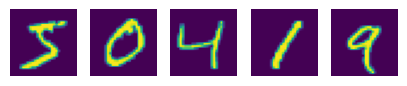

In [5]:
train, val, test = load_datasets()

<a name='4.1'></a>
### Dimension Reduction using Autoencoders

In [6]:
def get_autoencoder(input_shape, latent_size):
    input_image = Input(shape=input_shape)
    
    # encoder
    x = Conv2D(8, 3, activation='relu', padding='same')(input_image)
    x = MaxPooling2D(2, padding='same')(x)

    x = Conv2D(16, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2, padding='same')(x)

    x = Conv2D(8, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2, padding='same')(x)

    # bottleneck
    x = Flatten()(x)
    encoded = Dense(latent_size)(x)

    x = Dense(4 * 4 * 8)(encoded)
    x = Reshape((4, 4, 8))(x)

    # decoder
    x = Conv2D(8, 3, activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)

    x = Conv2D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)
    
    x = Conv2D(8, 3, activation='relu')(x)
    x = UpSampling2D(2)(x)

    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    encoder = Model(input_image, encoded)
    decoder = Model(encoded, decoded)
    autoencoder = Model(input_image, decoded)
    
    return autoencoder, encoder, decoder

In [7]:
autoencoder, ae_encoder, ae_decoder = get_autoencoder((28,28,1), LATENT_SIZE)

In [8]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           1160

In [9]:
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss=tf.keras.losses.MeanSquaredError())

In [10]:
hist = autoencoder.fit(train[0],train[0],
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(val[0], val[0]))

Epoch 1/50


I0000 00:00:1708321836.178820      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 11s 8ms/step - loss: 0.0562 - accuracy: 0.8008 - val_loss: 0.0268 - val_accuracy: 0.8052
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0232 - accuracy: 0.8072 - val_loss: 0.0202 - val_accuracy: 0.8076
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0192 - accuracy: 0.8094 - val_loss: 0.0174 - val_accuracy: 0.8098
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0172 - accuracy: 0.8104 - val_loss: 0.0160 - val_accuracy: 0.8106
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0159 - accuracy: 0.8110 - val_loss: 0.0149 - val_accuracy: 0.8117
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0149 - accuracy: 0.8115 - val_loss: 0.0140 - val_accuracy: 0.8119
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0141 - accuracy: 0.8118 - val_loss: 0.0134 - val_accuracy: 0.8122
Epoch 8/50
469/4

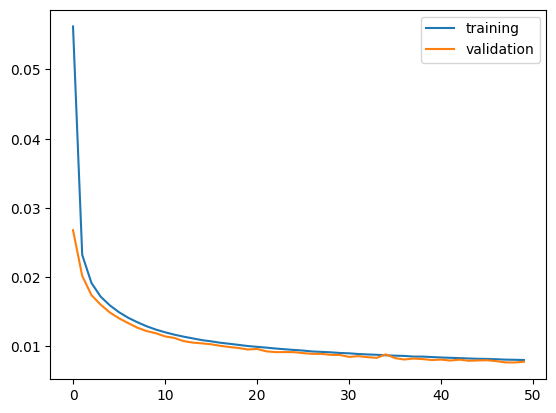

In [11]:
plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


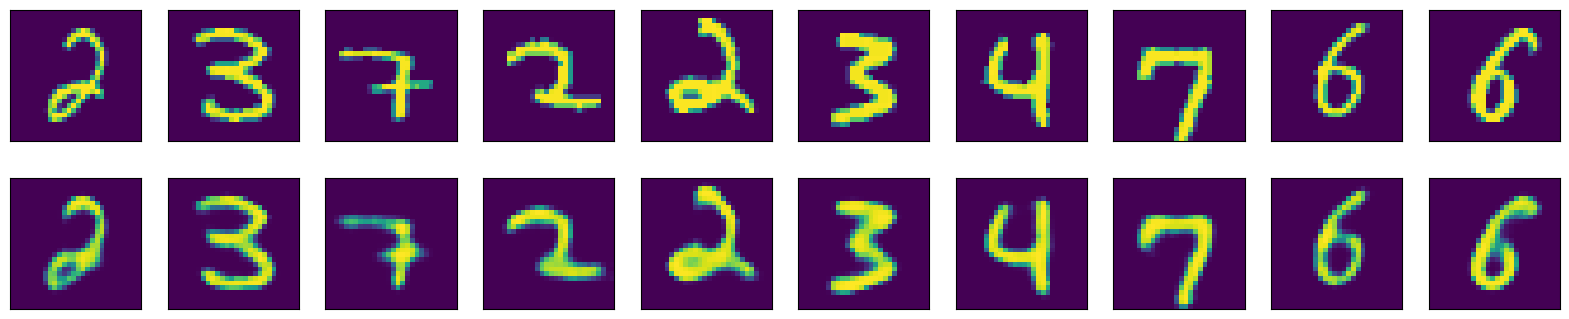

In [12]:
visualize_predictions(autoencoder, test[0], test[1], 10)

40/40 [==============================] - 0s 2ms/step


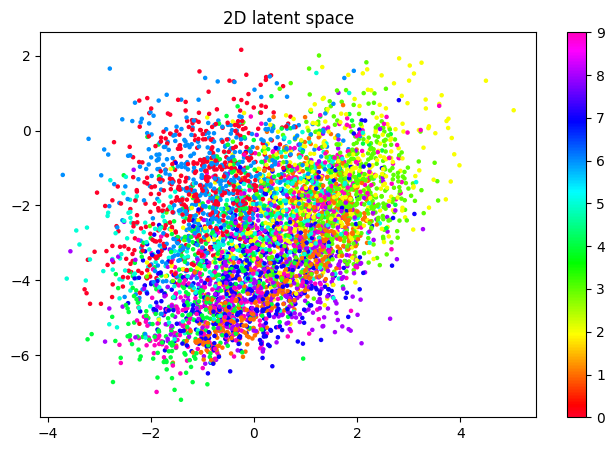

In [13]:
visualize_latentspace(test[0], test[1], ae_encoder, False)

157/157 [==============================] - 0s 1ms/step


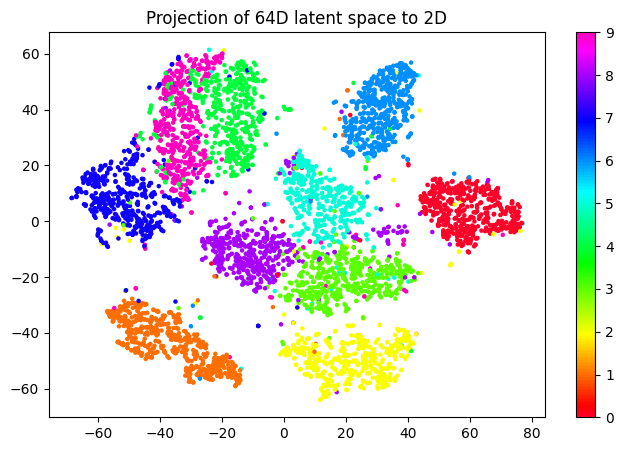

In [14]:
visualize_projection(test[0], test[1], ae_encoder, LATENT_SIZE, False)

1/1 [==============================] - 0s 17ms/step


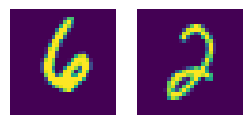

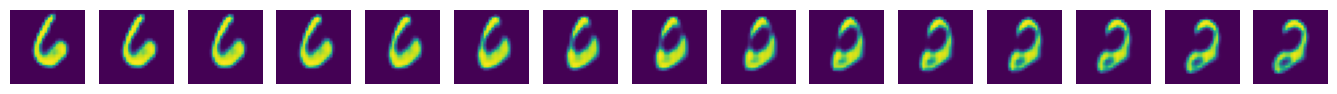

In [15]:
visualize_interpolation(test[0], test[1], ae_encoder, ae_decoder, 15, 'ae_interpolate.png', False)

<a name='4.2'></a>
### Hand-written Image Generator

In [16]:
class Sampling(tf.keras.layers.Layer):
    def call(self, params):
        mean, log_var = params
        
        epsilon = tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1])) # #batches * latent size
        z = mean + tf.exp(0.5 * log_var) * epsilon
        
        return z

In [17]:
def get_encoder(input_shape, latent_size):
    inputs = Input(shape=input_shape)
    
    # encoder
    x = Conv2D(40, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, padding='same')(x)

    x = Conv2D(80, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, padding='same')(x)

    # bottleneck
    x = Flatten()(x)
    encoded = Dense(50)(x)
    
    mean = Dense(latent_size)(encoded)
    log_var = Dense(latent_size)(encoded)
    
    # sampling
    z = Sampling()([mean, log_var])
    
    encoder = Model(inputs, [mean, log_var, z])
    
    return encoder

In [18]:
def get_decoder(latent_size):
    z = Input(shape=(latent_size,))
    
    x = Dense(7 * 7 * 80, activation='relu')(z)
    x = Reshape((7, 7, 80))(x)

    # decoder
    x = Conv2D(80, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)
    
    x = Conv2D(40, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)

    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    decoder = Model(z, decoded)
    
    return decoder

In [19]:
vae_encoder = get_encoder((28,28,1), VAE_LATENT_SIZE)
vae_encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 28, 28, 40)           400       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 40)           160       ['conv2d_7[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 40)           0         ['batch_normalization[0]

In [20]:
vae_decoder = get_decoder(VAE_LATENT_SIZE)
vae_decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_5 (Dense)             (None, 3920)              129360    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 80)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 80)          57680     
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 80)          320       
 chNormalization)                                                
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 14, 14, 80)        0         
 g2D)                                                      

In [21]:
class VAE(Model):
    def __init__(self, encoder, decoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        X, y = data
        with tf.GradientTape() as tape:
            mean, log_var, z = self.encoder(X)
            outputs = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(X, outputs), axis=(1, 2)))
            kl_loss = 1 + log_var - tf.square(mean) - tf.exp(log_var)
            kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=1)
            total_loss = reconstruction_loss + kl_loss

        gradients = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.compiled_metrics._metrics[2].update_state(kl_loss)
        self.compiled_metrics._metrics[1].update_state(reconstruction_loss)
        self.compiled_metrics._metrics[0].update_state(total_loss)

        return{"kl_loss":self.compiled_metrics._metrics[2].result(),
               "reconstruction_loss":self.compiled_metrics._metrics[1].result(),
               "loss":self.compiled_metrics._metrics[0].result()}

    def test_step(self, data):
        X, y = data
        mean, log_var, z = self.encoder(X)
        outputs = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(X, outputs), axis=(1, 2)))
        kl_loss = 1 + log_var - tf.square(mean) - tf.exp(log_var)
        kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=1)
        total_loss = reconstruction_loss + kl_loss

        self.compiled_metrics._metrics[2].update_state(kl_loss)
        self.compiled_metrics._metrics[1].update_state(reconstruction_loss)
        self.compiled_metrics._metrics[0].update_state(total_loss)

        return{"kl_loss":self.compiled_metrics._metrics[2].result(),
               "reconstruction_loss":self.compiled_metrics._metrics[1].result(),
               "loss":self.compiled_metrics._metrics[0].result()}
    
    def predict(self, X):
        mean, log_var, z = self.encoder(X)
        outputs = self.decoder(z)
        return outputs

In [22]:
vae = VAE(vae_encoder, vae_decoder)

In [23]:
vae.compile(optimizer='adam', 
            metrics=[tf.keras.metrics.Mean(name="total_loss"), 
                     tf.keras.metrics.Mean(name="reconstruction_loss"),
                     tf.keras.metrics.Mean(name="kl_loss")])

In [24]:
vae_hist = vae.fit(train[0],train[0],
                epochs=200,
                batch_size=BATCH_SIZE,
                validation_data=(val[0], val[0]))

Epoch 1/200
469/469 [==============================] - 12s 13ms/step - kl_loss: 0.1568 - reconstruction_loss: 89.9786 - loss: 90.1355 - val_kl_loss: 0.0310 - val_reconstruction_loss: 88.2175 - val_loss: 88.2633
Epoch 2/200
469/469 [==============================] - 5s 11ms/step - kl_loss: 0.0219 - reconstruction_loss: 88.1487 - loss: 88.1810 - val_kl_loss: 0.0155 - val_reconstruction_loss: 88.0506 - val_loss: 88.0815
Epoch 3/200
469/469 [==============================] - 5s 11ms/step - kl_loss: 0.8984 - reconstruction_loss: 80.9733 - loss: 81.8719 - val_kl_loss: 2.5064 - val_reconstruction_loss: 70.8619 - val_loss: 73.3889
Epoch 4/200
469/469 [==============================] - 5s 11ms/step - kl_loss: 3.6374 - reconstruction_loss: 64.4077 - loss: 68.0505 - val_kl_loss: 4.7382 - val_reconstruction_loss: 58.1493 - val_loss: 62.9025
Epoch 5/200
469/469 [==============================] - 5s 11ms/step - kl_loss: 5.4534 - reconstruction_loss: 54.1657 - loss: 59.6246 - val_kl_loss: 6.1672 - va

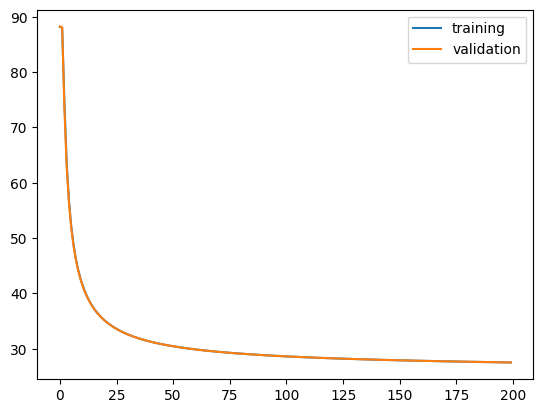

In [25]:
plt.plot(vae_hist.history['loss'], label='training')
plt.plot(vae_hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

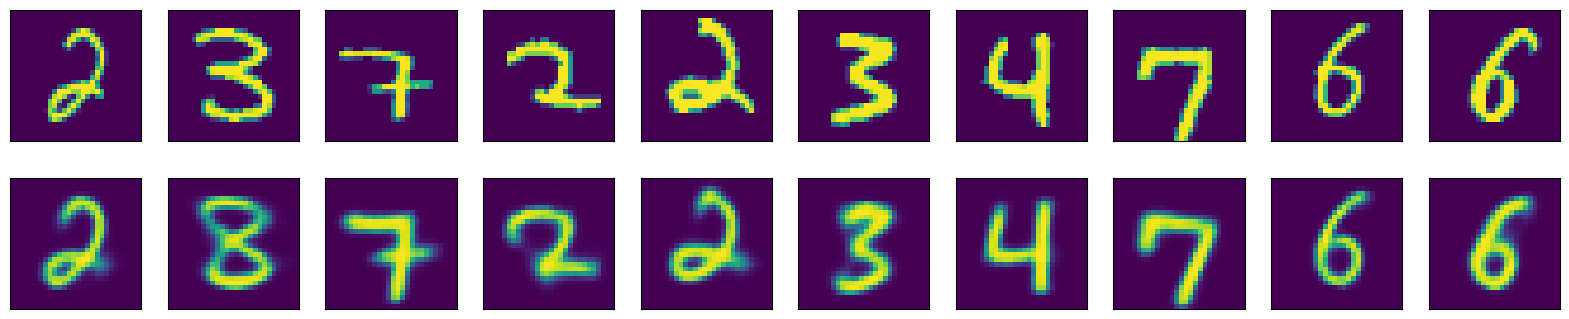

In [26]:
visualize_predictions(vae, test[0], test[1], 10)

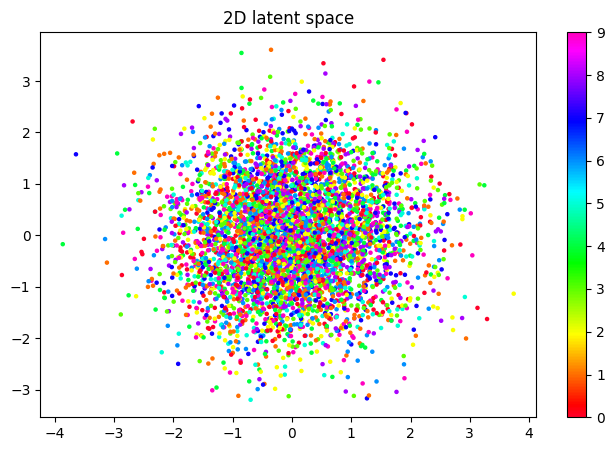

In [27]:
visualize_latentspace(test[0], test[1], vae_encoder, True)

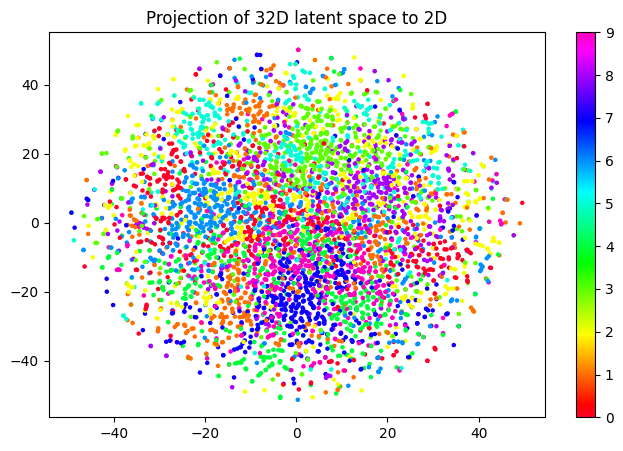

In [28]:
visualize_projection(test[0], test[1], vae_encoder, VAE_LATENT_SIZE, True)

1/1 [==============================] - 0s 18ms/step


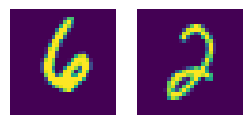

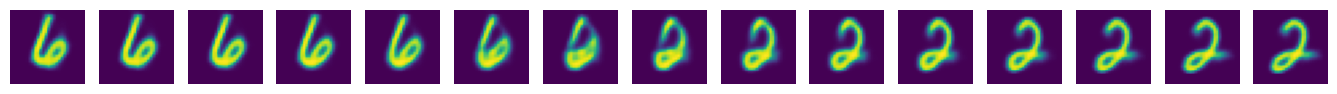

In [29]:
visualize_interpolation(test[0], test[1], vae_encoder, vae_decoder, 15, 'vae_interpolate.png', True)